In [1]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
#matplotlib.rcParams['font.serif'] = "Times New Roman"
#matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams["figure.dpi"] = 100

In [2]:
import camb
import copy
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import h5py

import fisher_matrix as fm

In [3]:
additional_parameters = {}
p_list = [ 'thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe', 'w', 'mnu', 'omk']
h_list = [5e-6, 0.01, 0.0001, 0.0015, 0.05*2e-9, 0.01, 0.004, 0.008, 0.1, 0.005, 0.001]
v_list = [1.0411e-2, 3.046, 0.022300, 0.1188, np.exp(3.044)*1e-10, 0.9649, 0.0544, 0.239, -1, 0.06, 0]
dv_list = [3.1e-6, 1e100, 0.00015, 0.0012, (np.exp(0.014)-1)*np.exp(3.044)*1e-10, 0.0042, 0.0073, 0.025, 0.031, 1e100, 0.012]


# h_list = [2e-5, 0.08, 0.0008, 0.002, 3e-11, 0.01, 0.02, 0.05]
# v_list = [1.04112e-2, 3.046, 0.022300, 0.1188, np.exp(3.064)*1e-10, 0.9667, 0.066, 0.2478, ]


i = -1
for key in p_list:
    i += 1
    pp = {}
    pp['value'] = v_list[i]
    pp['stdev'] = dv_list[i]
    pp['h'] = h_list[i]
    additional_parameters[key] = pp
    
additional_parameters

{'thetastar': {'value': 0.010411, 'stdev': 3.1e-06, 'h': 5e-06},
 'nnu': {'value': 3.046, 'stdev': 1e+100, 'h': 0.01},
 'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0001},
 'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.0015},
 'As': {'value': 2.0989031673191437e-09,
  'stdev': 2.959130012032031e-11,
  'h': 1.0000000000000002e-10},
 'ns': {'value': 0.9649, 'stdev': 0.0042, 'h': 0.01},
 'tau': {'value': 0.0544, 'stdev': 0.0073, 'h': 0.004},
 'YHe': {'value': 0.239, 'stdev': 0.025, 'h': 0.008},
 'w': {'value': -1, 'stdev': 0.031, 'h': 0.1},
 'mnu': {'value': 0.06, 'stdev': 1e+100, 'h': 0.005},
 'omk': {'value': 0, 'stdev': 0.012, 'h': 0.001}}

In [4]:
planck_parameters = {}
planck_parameters['f_sky'] = 0.8
planck_parameters['observables'] = ['TT', 'TE', 'EE']

# GHz
planck_parameters['frequency'] = np.array([30, 44, 70, 100, 143, 217, 353])
# arcmin
planck_parameters['theta_b'] = np.array([33, 23, 14, 10, 7, 5, 5])
# muK arcmin
planck_parameters['Delta_T'] = np.array([145, 149, 137, 65, 43, 66, 200])
planck_parameters['Delta_P'] = np.array([np.nan, np.nan, 450, 103, 81, 134, 406])

In [11]:
def run_camb(p, lmax=5000):
    '''
    run camb with given parameters
    '''
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=None, 
                       ombh2=p['ombh2']['value'], 
                       omch2=p['omch2']['value'], 
                       tau=p['tau']['value'], 
                       YHe=p['YHe']['value'], 
                       thetastar=p['thetastar']['value'], 
                       nnu=p['nnu']['value'],
                       mnu=p['mnu']['value'],
                       omk=p['omk']['value'],
                      )
    pars.InitPower.set_params(As=p['As']['value'], ns=p['ns']['value'])
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    pars.set_dark_energy(w=p['w']['value'])
    pars.NonLinear = camb.model.NonLinear_none
    res = camb.get_results(pars)
    return pars, res


def get_cmb_power_spectra(pars, res, specify='unlensed_scalar'):
    '''
    get cmb spectra
    '''
    powers = res.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)
    dat = powers[specify]
    spectra = {}
    keys = ['TT', 'EE', 'BB', 'TE']
    for j in range(4):
        spectra[keys[j]] = dat[:,j]
    return spectra

In [12]:
p = copy.deepcopy(additional_parameters)

In [13]:
class cmb:
    def __init__(self, cosmology, survey):
        self.cosmology = cosmology
        self.survey = survey
        pars, res = run_camb(self.cosmology)
        self.pars = pars
        self.res = res
        self.spectra = get_cmb_power_spectra(self.pars, self.res)
        self.l = np.arange(len(self.spectra['TT']))
        
    def get_noise_power_spectra(self, X):
        N = 0.
        if X[0] != X[1]:
            return np.zeros(self.l.shape)
        for i in range(len(self.survey['frequency'])):
            theta_b = self.survey['theta_b'][i]/60*np.pi/180
            sens = []
            for j in range(2):
                if X[j] in ['T']:
                    sens.append(self.survey['Delta_T'][i]/60*np.pi/180)
                else:
                    sens.append(self.survey['Delta_P'][i]/60*np.pi/180)
            if np.isnan(sens).any():
                continue
            N_temp = np.prod(sens)*np.exp(self.l*(self.l+1)*theta_b**2/(8*np.log(2)))
            N += 1/N_temp
        N = 1/N
        return N
    
    def get_power_spectra_cov(self, X, Y):
        a = X[0]
        b = X[1]
        c = Y[0]
        d = Y[1]
        res = 0.
        
        L, R = '', ''
        if a+c in self.spectra:
            L = a+c
        if c+a in self.spectra:
            L = c+a
        if b+d in self.spectra:
            R = b+d
        if d+b in self.spectra:
            R = d+b
        if L != '' and R != '':
            res += (self.spectra[L]+self.get_noise_power_spectra(L))*(self.spectra[R]+self.get_noise_power_spectra(R))
               
        L, R = '', ''
        if a+d in self.spectra:
            L = a+d
        if d+a in self.spectra:
            L = d+a
        if b+c in self.spectra:
            R = b+c
        if c+b in self.spectra:
            R = c+b
        if L != '' and R != '':
            res += (self.spectra[L]+self.get_noise_power_spectra(L))*(self.spectra[R]+self.get_noise_power_spectra(R))
        res /= (2*self.l+1)*self.survey['f_sky']
        return res
    
    def get_power_spectra_derivative(self, key, verbose=False):
        step = self.cosmology[key]['h']
        cs = []
        for fac in [1, -1]:
            p = copy.deepcopy(self.cosmology)
            p[key]['value'] += step*fac
            if verbose:
                print(key, p[key]['value'], p[key]['h'])
            c = cmb(p, None)
            if verbose:
                plt.plot(c.spectra['TT'])
            cs.append(c)
        spectra_derivative = {}
        for X in self.survey['observables']:
            spectra_derivative[X] = (cs[0].spectra[X]-cs[1].spectra[X])/(2*step)
        return spectra_derivative
    
    def get_power_spectra_fisher(self, lmin=2, lmax=29, verbose=False):
        fid = cmb(self.cosmology, self.survey)
        n = len(self.cosmology)
        n_cov = len(self.survey['observables'])
        keys = list(self.cosmology.keys())
        X_keys = self.survey['observables']
        covs = np.zeros((lmax-lmin+1, n_cov, n_cov))
        for i in range(n_cov):
            for j in range(n_cov):
                #print(i, j, X_keys[i], X_keys[j])
                covs[:, i, j] = self.get_power_spectra_cov(X_keys[i], X_keys[j])[lmin:lmax+1]
        #print(covs[10])
                
                
        deris = np.zeros((lmax-lmin+1, n, n_cov))
        for i in tqdm(range(n)):
            dv = self.get_power_spectra_derivative(keys[i])
            for j in range(n_cov):
                X = X_keys[j]
                deris[:, i, j] = dv[X][lmin:lmax+1]
        
        
        fisher = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                for l in range(lmin, lmax+1):
                    cov = covs[l-lmin]
                    dc1 = deris[l-lmin, i]
                    dc2 = deris[l-lmin, j]
                    fisher[i, j] += dc1.dot(np.linalg.inv(cov)).dot(dc2)
        return fisher
    
def get_constraints(fisher):
    return np.sqrt(np.diagonal(np.linalg.inv(fisher)))

In [14]:
c = cmb(p, planck_parameters)

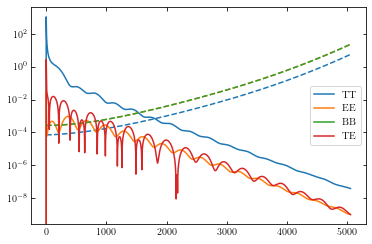

In [15]:
for key in c.spectra:
    pl = plt.plot(np.abs(c.spectra[key])[:], label=key)
    plt.semilogy(c.get_noise_power_spectra(key)[:], c=pl[0].get_color(), ls='--')
plt.legend()

## Planck

In [16]:
p = copy.deepcopy(additional_parameters)

planck_sp1 = copy.deepcopy(planck_parameters)
planck_sp1['f_sky'] = 0.8
planck_sp1['observables'] = ['TT']
planck_c1 = cmb(p, planck_sp1)

planck_sp2 = copy.deepcopy(planck_parameters)
planck_sp2['f_sky'] = 0.44
planck_sp2['observables'] = ['TT', 'TE', 'EE']
planck_c2 = cmb(p, planck_sp2)

In [17]:
print(planck_c1.survey)
print(planck_c2.survey)

{'f_sky': 0.8, 'observables': ['TT'], 'frequency': array([ 30,  44,  70, 100, 143, 217, 353]), 'theta_b': array([33, 23, 14, 10,  7,  5,  5]), 'Delta_T': array([145, 149, 137,  65,  43,  66, 200]), 'Delta_P': array([ nan,  nan, 450., 103.,  81., 134., 406.])}
{'f_sky': 0.44, 'observables': ['TT', 'TE', 'EE'], 'frequency': array([ 30,  44,  70, 100, 143, 217, 353]), 'theta_b': array([33, 23, 14, 10,  7,  5,  5]), 'Delta_T': array([145, 149, 137,  65,  43,  66, 200]), 'Delta_P': array([ nan,  nan, 450., 103.,  81., 134., 406.])}


In [18]:
fisher = planck_c1.get_power_spectra_fisher(2, 29) + planck_c2.get_power_spectra_fisher(30, 2500)
# add 0.01 prior on tau
fisher[6, 6] += 100**2
convert_beta = False

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
keys = p_list
F = fm.fisher(fisher, keys)
F.save('CMB_fisher/planck_cmb_fisher_original.hdf5')

In [14]:
# thetastar -> alpha
fisher[0] *= additional_parameters['thetastar']['value']
fisher[:,0] *= additional_parameters['thetastar']['value']

In [15]:
print(get_constraints(fisher[:, :]))
print(get_constraints(fisher[:7, :7]))

[8.52313461e-04 3.16742636e-01 2.58475934e-04 4.91387837e-03
 4.60226074e-11 9.27271647e-03 9.93799397e-03 1.78198278e-02]
[5.20301015e-04 2.10499090e-01 2.51666786e-04 3.10454869e-03
 4.51842628e-11 9.14787703e-03 9.93164000e-03]


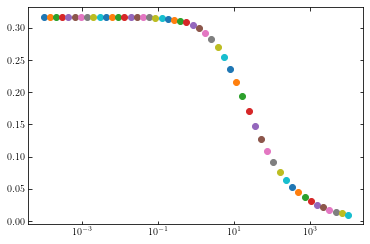

In [16]:
for x in np.logspace(-4, 4):
    fisher[1, 1] += x
    plt.scatter(x, get_constraints(fisher[:, :])[1])
    fisher[1, 1] -= x
plt.xscale('log')

In [17]:
def b2n(x):
    return 4.4* (x)/(2.45 - (x))

y, dy = 1, 0.0001
dndb = (b2n(y+dy)-b2n(y))/dy

# nnu -> beta
if not convert_beta:
    fisher[1] *= dndb
    fisher[:,1] *= dndb
    convert_beta = True
    
print(fisher)

[[ 1.67152900e+07  4.34101633e+05 -6.46403457e+06  1.77903828e+06
  -5.03315804e+14 -8.66176899e+05  2.11273772e+06  6.77443609e+05]
 [ 4.34101633e+05  5.06969917e+04 -8.85816368e+05 -1.98863036e+04
  -4.95605001e+13 -1.15544553e+05  2.08167978e+05  9.49135896e+04]
 [-6.46403457e+06 -8.85816368e+05  7.28652810e+07  7.08470197e+06
  -3.61477589e+14  6.61909447e+05  1.52110954e+06 -1.04029716e+06]
 [ 1.77903828e+06 -1.98863036e+04  7.08470197e+06  3.08899505e+06
  -4.80049240e+14 -1.64658910e+05  2.01207292e+06  2.56254538e+05]
 [-5.03315804e+14 -4.95605001e+13 -3.61477589e+14 -4.80049240e+14
   1.39572206e+23  1.48290431e+14 -5.85397662e+14 -1.43177695e+14]
 [-8.66176899e+05 -1.15544553e+05  6.61909447e+05 -1.64658910e+05
   1.48290431e+14  3.17005333e+05 -6.23646162e+05 -2.45633587e+05]
 [ 2.11273772e+06  2.08167978e+05  1.52110954e+06  2.01207292e+06
  -5.85397662e+14 -6.23646162e+05  2.46548022e+06  6.00863933e+05]
 [ 6.77443609e+05  9.49135896e+04 -1.04029716e+06  2.56254538e+05
  -

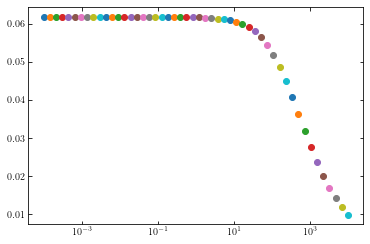

In [18]:
for x in np.logspace(-4, 4):
    fisher[1, 1] += x
    plt.scatter(x, get_constraints(fisher[:, :])[1])
    fisher[1, 1] -= x
plt.xscale('log')

In [19]:
np.savetxt('planck_cmb_fisher.txt', fisher)

In [20]:
keys = [ 'alpha', 'beta', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe',]
F = fm.fisher(fisher, keys)
F.save('planck_cmb_fisher.hdf5')

## CMB-S3

In [23]:
cmb_s3_parameters = {}
cmb_s3_parameters['f_sky'] = 0.3
cmb_s3_parameters['observables'] = ['TT', 'TE', 'EE']

# GHz
cmb_s3_parameters['frequency'] = np.array([None])
# arcmin
cmb_s3_parameters['theta_b'] = np.array([3])
# muK arcmin
cmb_s3_parameters['Delta_T'] = np.array([5])
cmb_s3_parameters['Delta_P'] = np.array([5])

In [24]:
cmb_s3_sp1 = copy.deepcopy(cmb_s3_parameters)
cmb_s3_sp1['observables'] = ['TT', 'TE']
cmb_s3_c1 = cmb(p, cmb_s3_sp1)

cmb_s3_sp2 = copy.deepcopy(cmb_s3_parameters)
cmb_s3_sp2['observables'] = ['EE']
cmb_s3_c2 = cmb(p, cmb_s3_sp2)

planck_sp3 = copy.deepcopy(planck_parameters)
planck_sp3['f_sky'] = 0.3
planck_sp3['observables'] = ['TT', 'TE', 'EE']
planck_c3 = cmb(p, planck_sp3)

In [25]:
fisher = planck_c1.get_power_spectra_fisher(2, 29) + planck_c3.get_power_spectra_fisher(30, 2500) \
        + cmb_s3_c1.get_power_spectra_fisher(30, 3000) + cmb_s3_c2.get_power_spectra_fisher(30, 5000)
# add 0.01 prior on tau
fisher[6, 6] += 100**2
convert_beta = False

In [26]:
keys = p_list
F = fm.fisher(fisher, keys)
F.save('cmb_s3_fisher_original.hdf5')

In [27]:
# thetastar -> alpha
fisher[0] *= additional_parameters['thetastar']['value']
fisher[:,0] *= additional_parameters['thetastar']['value']

In [28]:
print(get_constraints(fisher[:, :]))
print(get_constraints(fisher[:7, :7]))

[2.42726847e-04 1.19394408e-01 8.11835485e-05 2.00401171e-03
 4.22448484e-11 3.92666650e-03 9.90827068e-03 6.89699826e-03]
[1.37079914e-04 6.50366761e-02 7.75554456e-05 1.14538717e-03
 4.20040450e-11 3.88711368e-03 9.90590213e-03]


In [29]:
# nnu -> beta
if not convert_beta:
    fisher[1] *= dndb
    fisher[:,1] *= dndb
    convert_beta = True
np.savetxt('cmb_s3_cmb_fisher.txt', fisher)

In [30]:
keys = [ 'alpha', 'beta', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe',]
F = fm.fisher(fisher, keys)
F.save('cmb_s3_cmb_fisher.hdf5')

## CMB-S4

In [31]:
cmb_s4_parameters = {}
cmb_s4_parameters['f_sky'] = 0.4
cmb_s4_parameters['observables'] = ['TT', 'TE', 'EE']

# GHz
cmb_s4_parameters['frequency'] = np.array([None])
# arcmin
cmb_s4_parameters['theta_b'] = np.array([2])
# muK arcmin
cmb_s4_parameters['Delta_T'] = np.array([1])
cmb_s4_parameters['Delta_P'] = np.array([1])

In [32]:
cmb_s4_sp1 = copy.deepcopy(cmb_s4_parameters)
cmb_s4_sp1['observables'] = ['TT', 'TE']
cmb_s4_c1 = cmb(p, cmb_s4_sp1)

cmb_s4_sp2 = copy.deepcopy(cmb_s4_parameters)
cmb_s4_sp2['observables'] = ['EE']
cmb_s4_c2 = cmb(p, cmb_s4_sp2)

planck_sp4 = copy.deepcopy(planck_parameters)
planck_sp4['f_sky'] = 0.2
planck_sp4['observables'] = ['TT', 'TE', 'EE']
planck_c4 = cmb(p, planck_sp4)

In [33]:
fisher = planck_c1.get_power_spectra_fisher(2, 29) + planck_c4.get_power_spectra_fisher(30, 2500) \
        + cmb_s4_c1.get_power_spectra_fisher(30, 3000) + cmb_s4_c2.get_power_spectra_fisher(30, 5000)
# add 0.01 prior on tau
fisher[6, 6] += 100**2
convert_beta = False

In [34]:
keys = p_list
F = fm.fisher(fisher, keys)
F.save('cmb_s4_fisher_original.hdf5')

In [35]:
# thetastar -> alpha
fisher[0] *= additional_parameters['thetastar']['value']
fisher[:,0] *= additional_parameters['thetastar']['value']

In [36]:
print(get_constraints(fisher[:, :]))
print(get_constraints(fisher[:7, :7]))

[1.45937686e-04 8.38485886e-02 5.11505023e-05 1.46653822e-03
 4.19106724e-11 3.23870297e-03 9.90364002e-03 5.02128939e-03]
[8.38306802e-05 4.44010657e-02 4.75247558e-05 8.73216100e-04
 4.17822380e-11 3.19744759e-03 9.90199387e-03]


In [37]:
# nnu -> beta
if not convert_beta:
    fisher[1] *= dndb
    fisher[:,1] *= dndb
    convert_beta = True
np.savetxt('cmb_s4_cmb_fisher.txt', fisher)

In [38]:
keys = [ 'alpha', 'beta', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe',]
F = fm.fisher(fisher, keys)
F.save('cmb_s4_cmb_fisher.hdf5')

## Derivative stability

thetastar


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


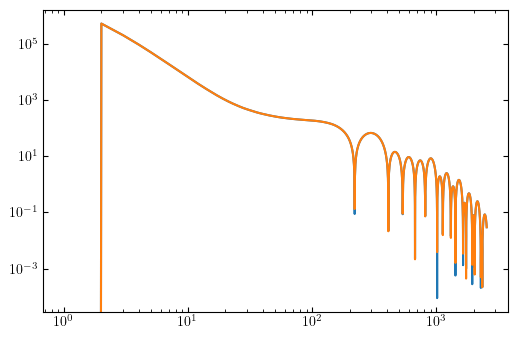

nnu


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


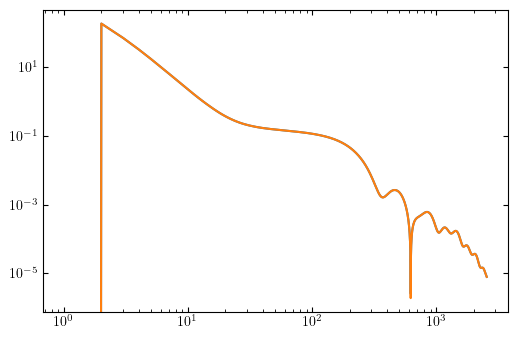

ombh2


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


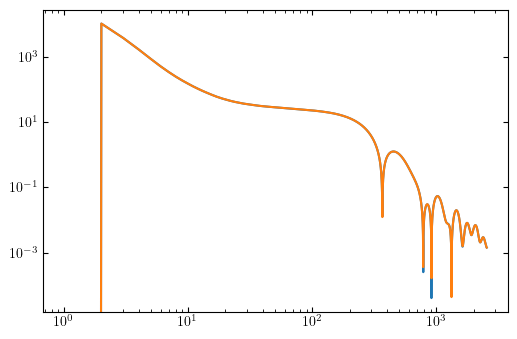

omch2


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


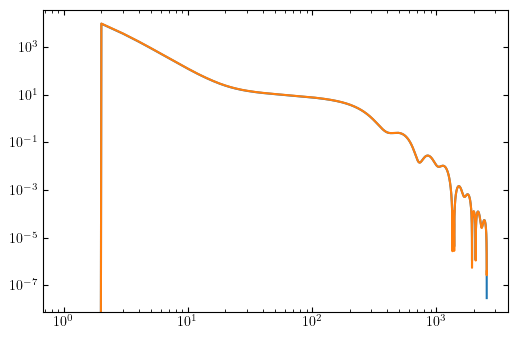

As


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


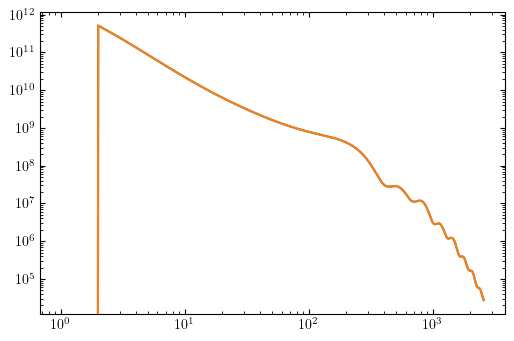

ns


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


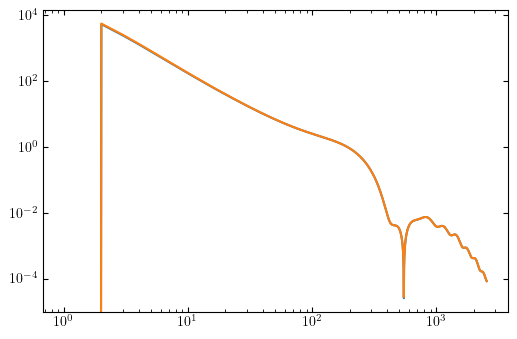

tau


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


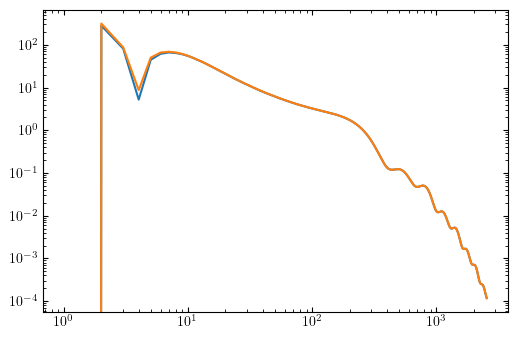

YHe


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\yanlo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


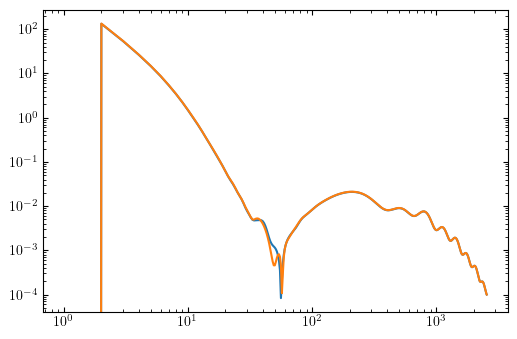

In [156]:
ks = np.linspace(0.01, 0.2)
facs = np.logspace(-1, 1, 2)
obv = 'TT'
survey_parameters['observables'] = [obv]
sp = copy.deepcopy(survey_parameters)

kk=7

j = 0
for key in list(additional_parameters.keys())[:]:
    print(key)
    p = copy.deepcopy(additional_parameters)
    h0 = p[key]['h']
    hs = h0*facs
    
    c = cmb(p, sp)
    dpdl0 = c.get_power_spectra_derivative(key, False)
    
    if j == 0:
        vmats = np.zeros((len(additional_parameters.keys()), c.l.shape[0], facs.shape[0]))
    
    i = 0
    for h in tqdm(hs):
        p[key]['h'] = h
        c = cmb(p, sp)
        dpdl = c.get_power_spectra_derivative(key, False)
        vmats[j][:,i] = dpdl[obv]/dpdl0[obv]
        plt.loglog(c.l, np.abs(dpdl[obv]))
        i += 1
    plt.show()
    j += 1

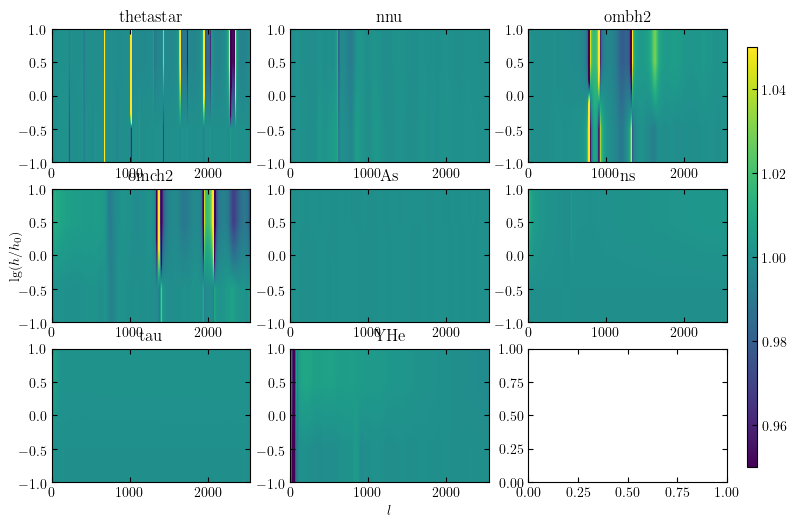

In [154]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

i = -1
for key in list(additional_parameters.keys())[:]:
    i += 1
    ax = axs[i//3, i%3]
    
    extent = c.l[0], c.l[-1], -1, 1
    im = ax.imshow(vmats[i].T, interpolation='bilinear', extent=extent, origin='lower', aspect='auto', vmax=1.05, vmin=0.95)
    # ax.set_yscale('log')
    ax.set_title(key.replace('_', '\_'))
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"$l$")
plt.ylabel(r"$\lg(h/h_0)$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()